# Visualizing Word Vectors with t-SNE

TSNE is pretty useful when it comes to visualizing similarity between objects. It works by taking a group of high-dimensional (100 dimensions via Word2Vec) vocabulary word feature vectors, then compresses them down to 2-dimensional x,y coordinate pairs. The idea is to keep similar words close together on the plane, while maximizing the distance between dissimilar words. 

### Steps

1. Clean the data
2. Build a corpus
3. Train a Word2Vec Model
4. Visualize t-SNE representations of the most common words 

Credit: Some of the code was inspired by this awesome [NLP repo][1]. 




  [1]: https://github.com/rouseguy/DeepLearningNLP_Py

In [15]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

train = pd.read_csv('data/train.csv')#.sample(50000, random_state=23)
test = pd.read_csv('data/test.csv')#.sample(50000, random_state=23)
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [16]:
data=train

In [17]:
STOP_WORDS = nltk.corpus.stopwords.words()

def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    data = data.dropna(how="any")
    
    for col in ['question1', 'question2']:
        data[col] = data[col].apply(clean_sentence)
    
    return data

data = clean_dataframe(data)
print(data.shape)
data.head(5)

TypeError: 'tuple' object is not callable

In [32]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

train_qs = pd.Series(train['question1'].tolist() + train['question2'].tolist()).astype(str)
test_qs = pd.Series(test['question1'].tolist() + test['question2'].tolist()).astype(str)
all_qs=pd.Series(train['question1'].tolist() + train['question2'].tolist()+test['question1'].tolist() + test['question2'].tolist()).astype(str)

eps = 5000 
#train_words = (" ".join(train_qs)).lower().split()#所有出现的词语
#test_words = (" ".join(test_qs)).lower().split()#所有出现的词语
all_qs_words=(" ".join(all_qs)).lower().split()#所有出现的词语

train_words_counts = Counter(train_words)#单词计数
test_words_counts = Counter(test_words)#单词计数
all_words_counts= Counter(all_qs_words)#单词计数

print("train_words_counts",len(train_words_counts))
print("test_words_counts",len(test_words_counts))
print("all_words_counts",len(all_words_counts))

train_words_counts 201102
test_words_counts 240714
all_words_counts 327522


In [23]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['question1', 'question2']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

corpus = build_corpus(data)        
corpus[0:2] 

808576


In [36]:
print(len(all_qs_words))
all_qs_words

60637804


['what',
 'is',
 'the',
 'step',
 'by',
 'step',
 'guide',
 'to',
 'invest',
 'in',
 'share',
 'market',
 'in',
 'india?',
 'what',
 'is',
 'the',
 'story',
 'of',
 'kohinoor',
 '(koh-i-noor)',
 'diamond?',
 'how',
 'can',
 'i',
 'increase',
 'the',
 'speed',
 'of',
 'my',
 'internet',
 'connection',
 'while',
 'using',
 'a',
 'vpn?',
 'why',
 'am',
 'i',
 'mentally',
 'very',
 'lonely?',
 'how',
 'can',
 'i',
 'solve',
 'it?',
 'which',
 'one',
 'dissolve',
 'in',
 'water',
 'quikly',
 'sugar,',
 'salt,',
 'methane',
 'and',
 'carbon',
 'di',
 'oxide?',
 'astrology:',
 'i',
 'am',
 'a',
 'capricorn',
 'sun',
 'cap',
 'moon',
 'and',
 'cap',
 'rising...what',
 'does',
 'that',
 'say',
 'about',
 'me?',
 'should',
 'i',
 'buy',
 'tiago?',
 'how',
 'can',
 'i',
 'be',
 'a',
 'good',
 'geologist?',
 'when',
 'do',
 'you',
 'use',
 'シ',
 'instead',
 'of',
 'し?',
 'motorola',
 '(company):',
 'can',
 'i',
 'hack',
 'my',
 'charter',
 'motorolla',
 'dcx3400?',
 'method',
 'to',
 'find',
 'sep

# Word 2 Vec

The Word to Vec model produces a vocabulary, with each word being represented by an n-dimensional numpy array (100 values in this example)

In [11]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)
model.wv['trump']

array([ 0.06186283, -0.13378508,  1.03641021, -0.68319958, -0.15513851,
        0.7427091 ,  0.17888591,  0.23124652, -0.57198584,  0.58398837,
       -0.17170179, -0.02503236, -1.06984508, -0.0732962 ,  0.62399268,
        0.55534339,  0.68611699, -1.01933813, -0.05922366, -0.64334959,
        0.1768772 ,  0.83798963, -1.08490372, -0.21098532,  0.58911657,
        0.16610257, -0.83999538,  0.25429159, -0.45857957, -0.86749083,
        0.2599088 , -0.94353265,  0.07165947, -0.15514979,  0.1901111 ,
        0.85218936,  0.18969966, -0.4531036 , -1.00182509, -0.57131112,
       -0.47141233, -0.99183345, -0.85319066, -0.31223431,  0.0165682 ,
       -1.48460662,  0.66461653,  0.13073944,  1.43527544, -0.47851557,
       -0.85772336,  1.29859459,  0.03304185, -0.55328798,  0.32454199,
        0.5407294 , -0.51889747, -0.14969254,  0.76495916,  0.43102777,
       -0.74345517,  0.22950982, -0.60477853, -0.32062721, -0.37518787,
       -0.77068704,  0.2969459 , -0.32131451, -0.71990389, -0.06

In [6]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

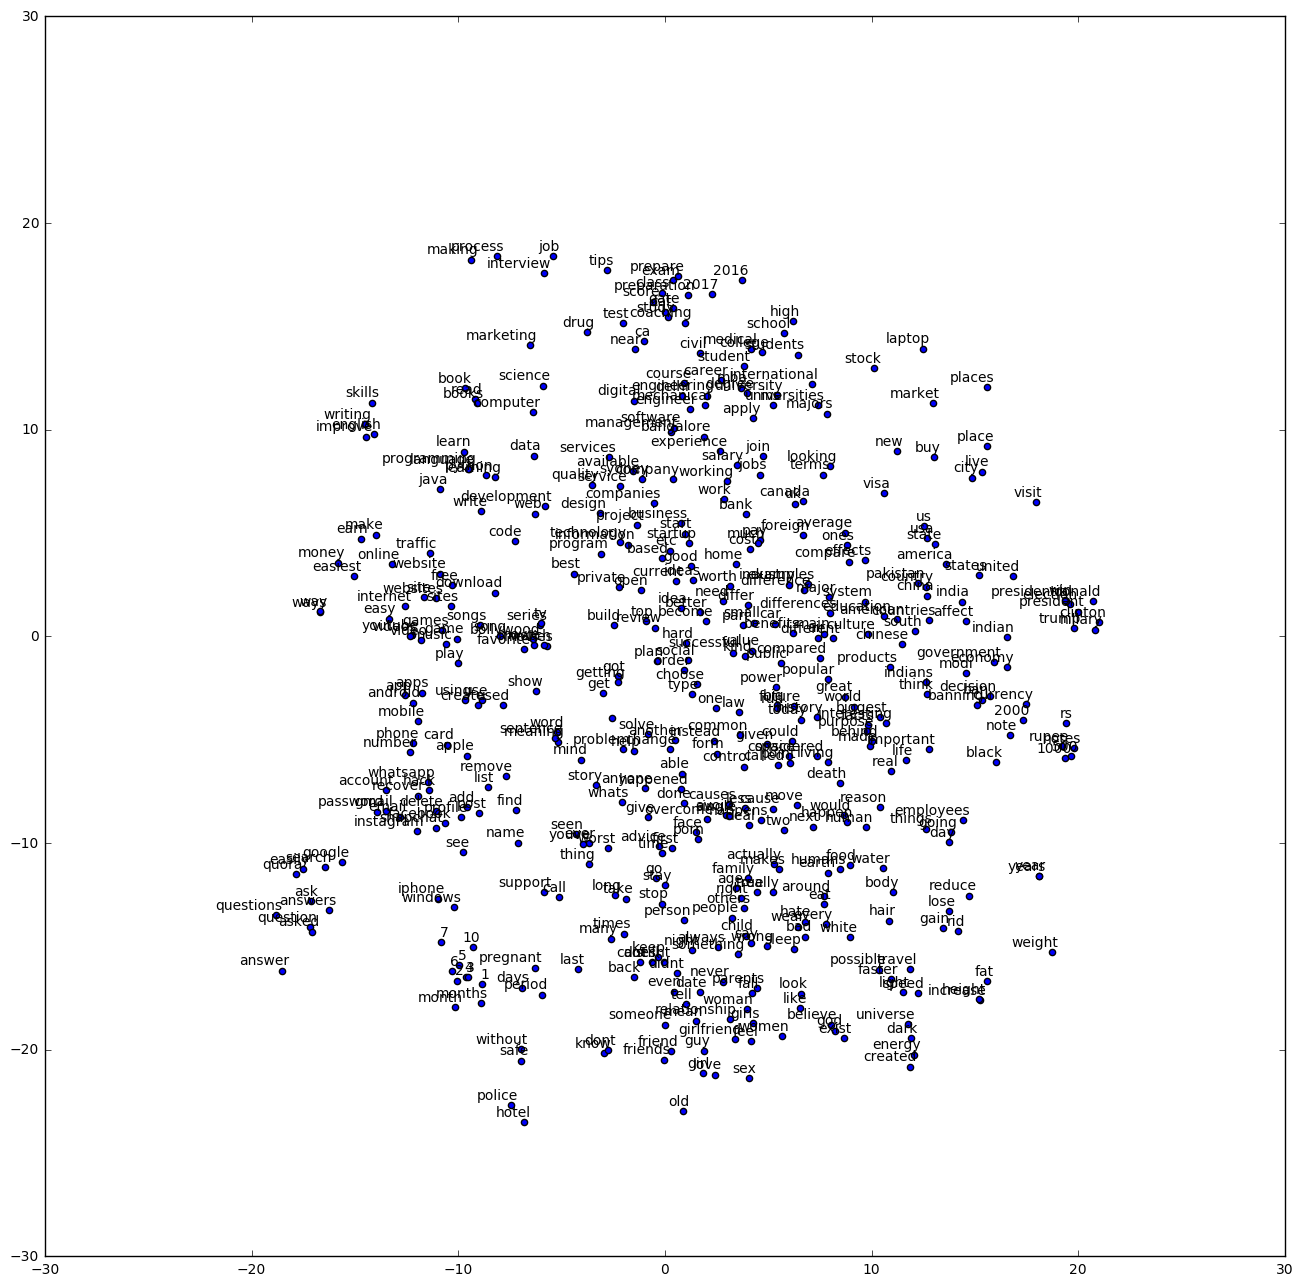

In [7]:
tsne_plot(model)

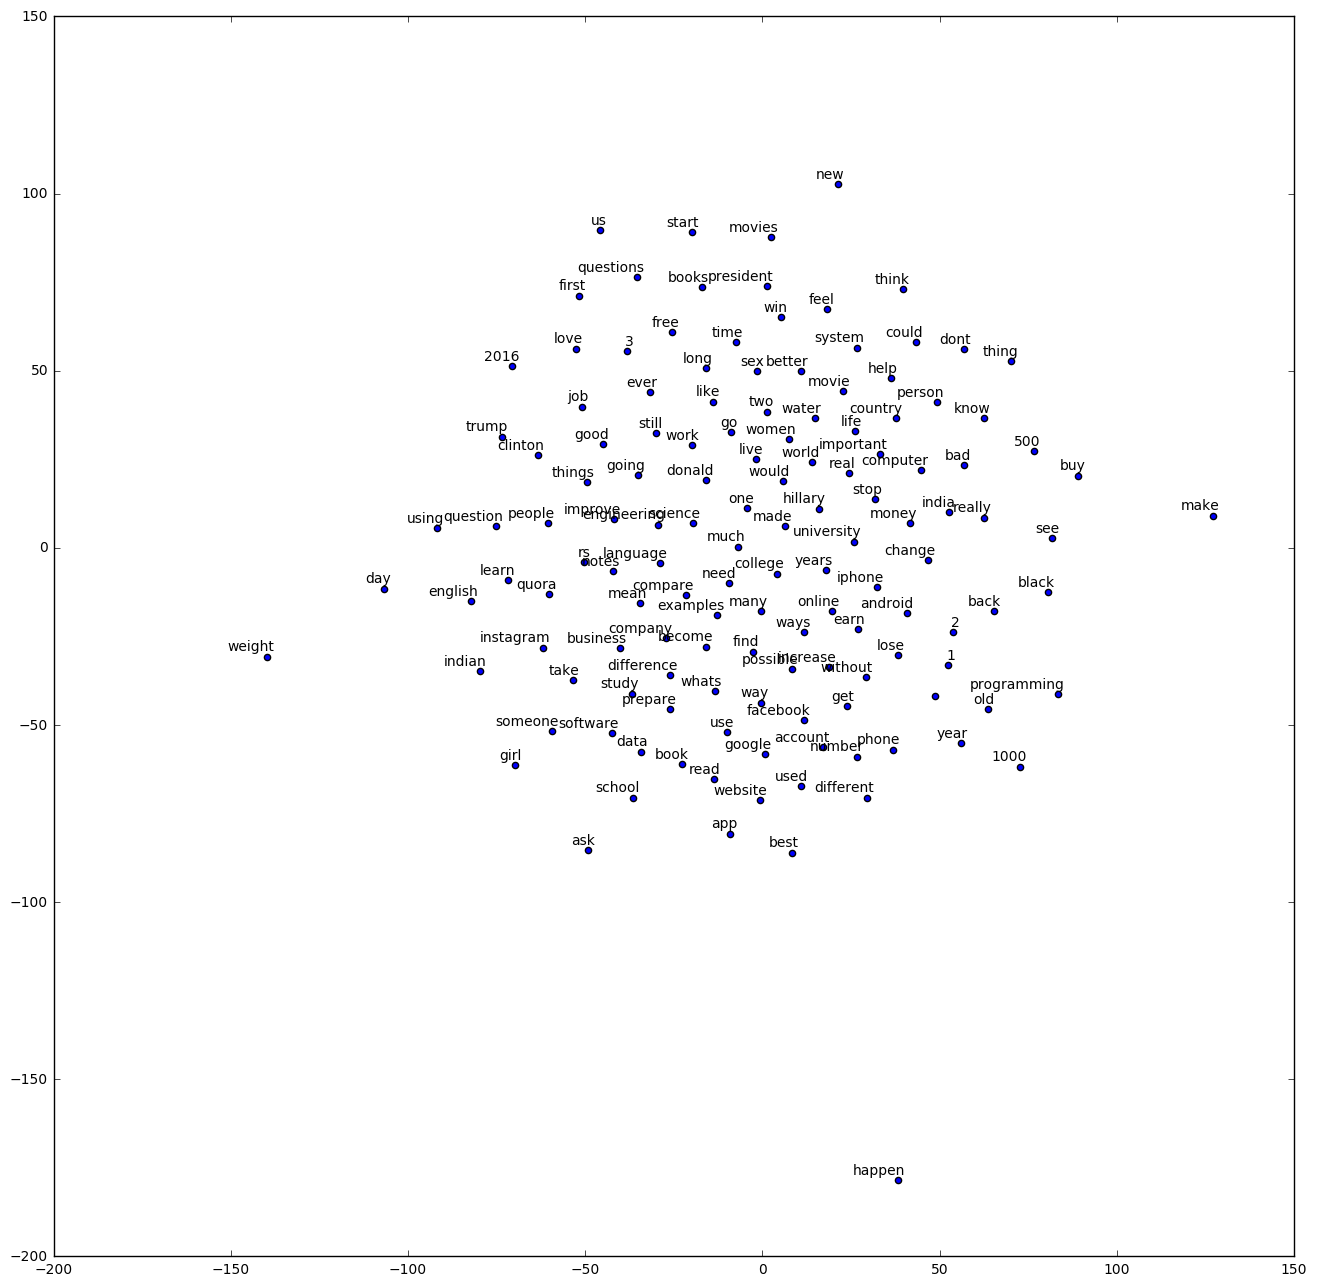

In [8]:
# A more selective model
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=500, workers=4)
tsne_plot(model)

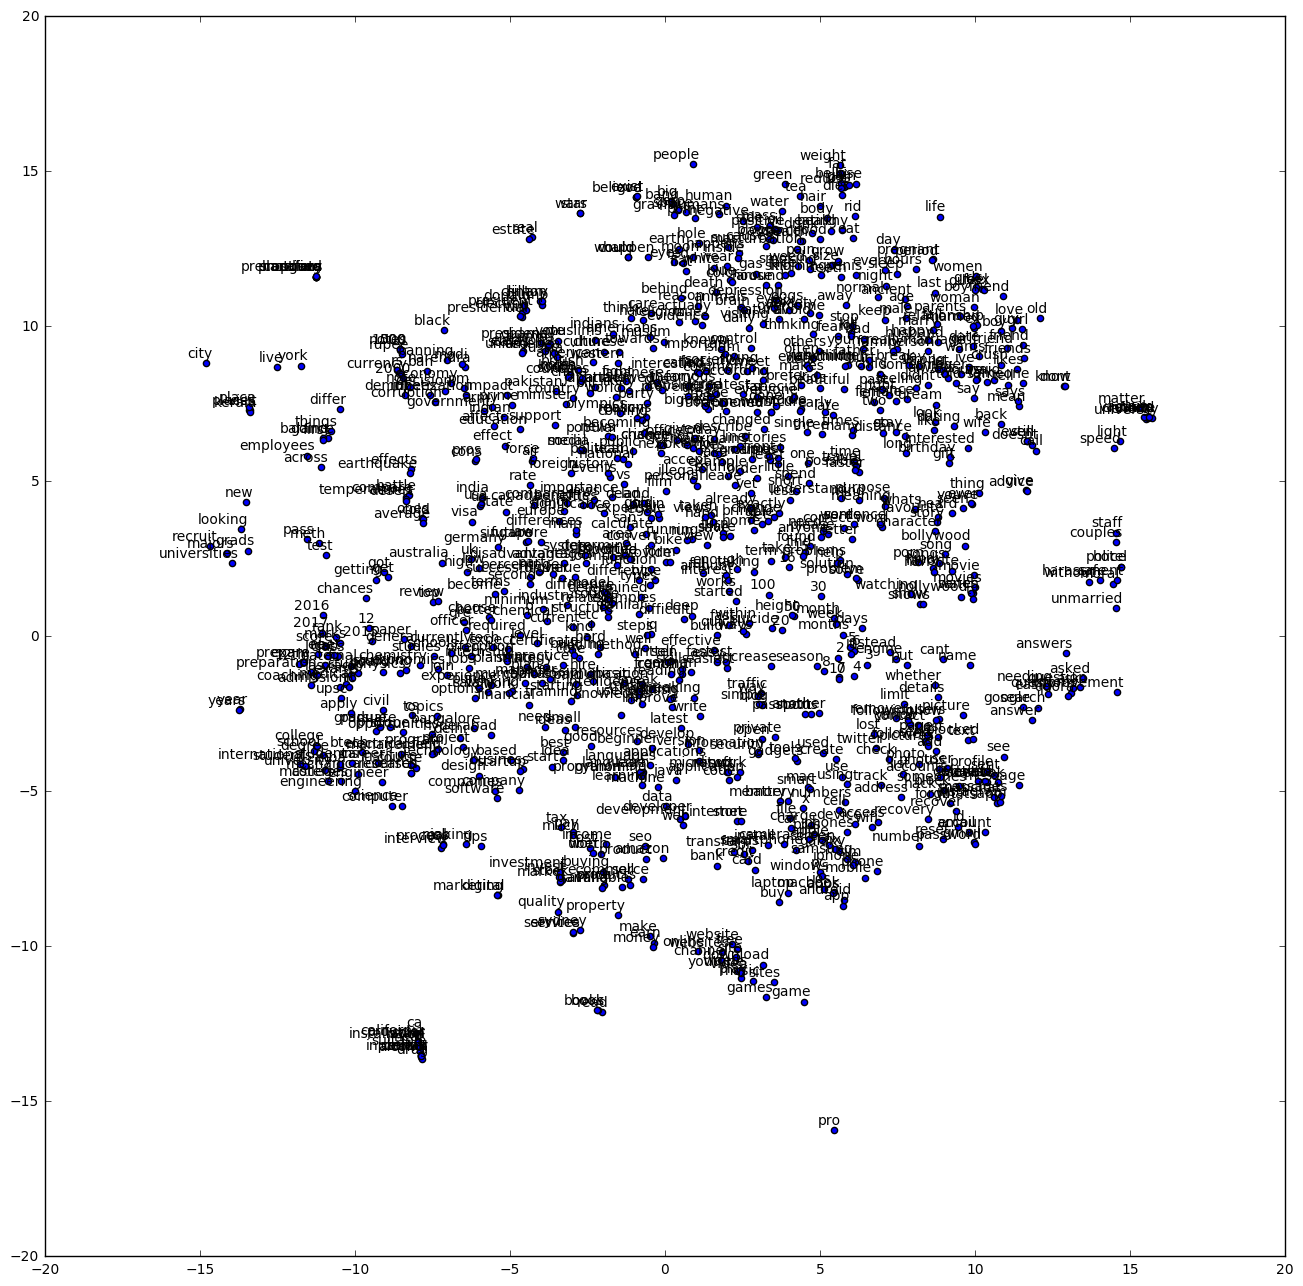

In [9]:
# A less selective model
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=100, workers=4)
tsne_plot(model)

# It's Becoming Hard to Read

With a dataset this large, its difficult to make an easy-to-read TSNE visualization. What you can do is use the model to look up the most similar words from any given point. 

In [10]:
model.most_similar('trump')

[('trumps', 0.8898810148239136),
 ('hillary', 0.8481696844100952),
 ('president', 0.8057031631469727),
 ('bill', 0.7986517548561096),
 ('obama', 0.7944045662879944),
 ('election', 0.7816380858421326),
 ('vote', 0.7595279216766357),
 ('clinton', 0.7426291108131409),
 ('presidency', 0.7337529063224792),
 ('becoming', 0.7330964207649231)]

In [11]:
model.most_similar('universe')

[('zero', 0.9403374791145325),
 ('created', 0.9300487041473389),
 ('vacuum', 0.9173840880393982),
 ('energy', 0.9063367247581482),
 ('space', 0.8940475583076477),
 ('dark', 0.8889486193656921),
 ('infinite', 0.8769468069076538),
 ('light', 0.8688271045684814),
 ('bang', 0.8634726405143738),
 ('gravity', 0.8632473349571228)]

# The End

Good luck!